In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('ADNI combined.xlsx', sheet_name='sample')
#print(df)
sid = df['RID']
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV']
field = df['MRI_Field_Strength']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
#dataAD = sorted(glob.glob('mwp1_MNI/AD/*.nii.gz'))
#dataLMCI = sorted(glob.glob('mwp1_MNI/LMCI/*.nii.gz'))
#dataCN = sorted(glob.glob('mwp1_MNI/CN/*.nii.gz'))
dataADNI3 = sorted(glob.glob('mwp1_MNI/ADNI3/*.nii.gz'))
dataFiles = dataADNI3 #dataAD + dataLMCI + dataCN + dataADNI3
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  575  nifti files


In [3]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load residualized data from disk
import h5py
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
hf = h5py.File('residuals_wb_mwp1_MNI_ADNI3.hdf5', 'r')
hf.keys # read keys
labels = np.array(hf.get('labels')) # note: was of data frame type before
images = np.array(hf.get('images'))
hf.close()
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
print(images.shape)

Using TensorFlow backend.


(575, 100, 100, 120, 1)


In [5]:
# specify version of tensorflow
#%tensorflow_version 1.x
#%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
#print(tf.__version__)
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = False #True
session = tf.Session(config=config)
set_session(session)

1.15.0


In [6]:
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((sen * spec) / (sen + spec))
    return sen, spec, ppv, npv, f1

validating model newmodel/newmodel_wb_cv1.hdf5
Test accuracy: 65.39 %


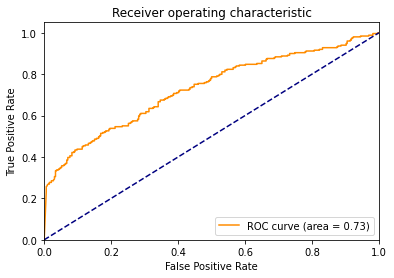

Optimal prediction threshold: 0.46805
Optimal prediction threshold: 0.99601
AUC for MCI vs. CN = 0.66
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.664
AUC for AD vs. CN = 0.920
Acc for MCI vs. CN = 62.6
Acc for AD vs. CN = 69.6
confusion matrix (naive)
[[215 111]
 [  0   0]
 [ 81 106]
 [  7  55]]
oAcc for MCI vs. CN = 63.2
oAcc for AD vs. CN = 89.4
confusion matrix (optimized)
[[215 111]
 [  0   0]
 [ 78 109]
 [  6  56]]
validating model newmodel/newmodel_wb_cv2.hdf5
Test accuracy: 64.00 %


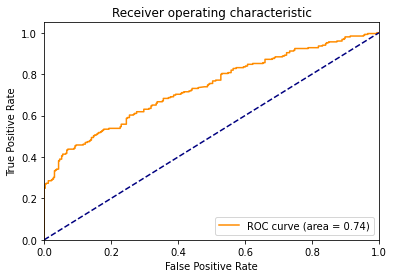

Optimal prediction threshold: 0.99567
Optimal prediction threshold: 0.95869
AUC for MCI vs. CN = 0.67
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.672
AUC for AD vs. CN = 0.927
Acc for MCI vs. CN = 60.4
Acc for AD vs. CN = 64.7
confusion matrix (naive)
[[193 133]
 [  0   0]
 [ 70 117]
 [  4  58]]
oAcc for MCI vs. CN = 70.8
oAcc for AD vs. CN = 83.8
confusion matrix (optimized)
[[303  23]
 [  0   0]
 [127  60]
 [ 14  48]]
validating model newmodel/newmodel_wb_cv3.hdf5
Test accuracy: 62.26 %


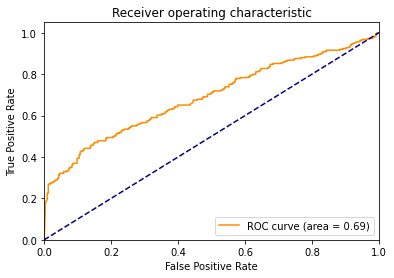

Optimal prediction threshold: 0.97703
Optimal prediction threshold: 0.99924
AUC for MCI vs. CN = 0.63
AUC for AD vs. CN = 0.87
AUC for MCI vs. CN = 0.626
AUC for AD vs. CN = 0.874
Acc for MCI vs. CN = 59.5
Acc for AD vs. CN = 65.2
confusion matrix (naive)
[[200 126]
 [  0   0]
 [ 82 105]
 [  9  53]]
oAcc for MCI vs. CN = 67.6
oAcc for AD vs. CN = 90.7
confusion matrix (optimized)
[[278  48]
 [  0   0]
 [118  69]
 [ 16  46]]
validating model newmodel/newmodel_wb_cv4.hdf5
Test accuracy: 64.87 %


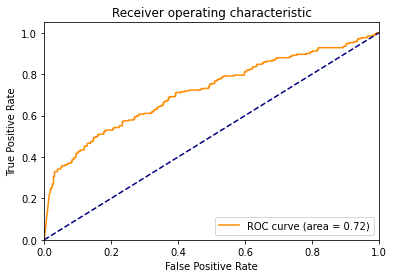

Optimal prediction threshold: 0.88980
Optimal prediction threshold: 0.97477
AUC for MCI vs. CN = 0.65
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.646
AUC for AD vs. CN = 0.930
Acc for MCI vs. CN = 61.0
Acc for AD vs. CN = 68.6
confusion matrix (naive)
[[206 120]
 [  0   0]
 [ 80 107]
 [  2  60]]
oAcc for MCI vs. CN = 65.3
oAcc for AD vs. CN = 83.2
confusion matrix (optimized)
[[249  77]
 [  0   0]
 [101  86]
 [  6  56]]
validating model newmodel/newmodel_wb_cv5.hdf5
Test accuracy: 69.22 %


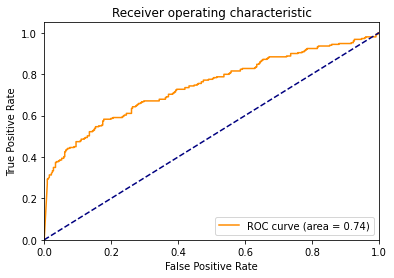

Optimal prediction threshold: 0.88994
Optimal prediction threshold: 0.99413
AUC for MCI vs. CN = 0.68
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.678
AUC for AD vs. CN = 0.936
Acc for MCI vs. CN = 66.3
Acc for AD vs. CN = 75.8
confusion matrix (naive)
[[236  90]
 [  0   0]
 [ 83 104]
 [  4  58]]
oAcc for MCI vs. CN = 69.6
oAcc for AD vs. CN = 89.2
confusion matrix (optimized)
[[268  58]
 [  0   0]
 [ 98  89]
 [  7  55]]
validating model newmodel/newmodel_wb_cv6.hdf5
Test accuracy: 64.87 %


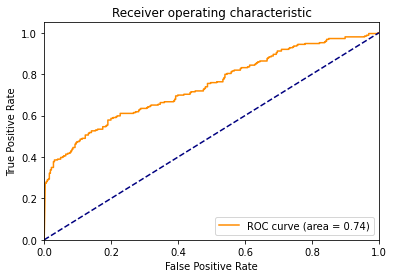

Optimal prediction threshold: 0.90275
Optimal prediction threshold: 0.99018
AUC for MCI vs. CN = 0.69
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.685
AUC for AD vs. CN = 0.919
Acc for MCI vs. CN = 61.6
Acc for AD vs. CN = 68.0
confusion matrix (naive)
[[207 119]
 [  0   0]
 [ 78 109]
 [  5  57]]
oAcc for MCI vs. CN = 68.0
oAcc for AD vs. CN = 86.6
confusion matrix (optimized)
[[252  74]
 [  0   0]
 [ 90  97]
 [  8  54]]
validating model newmodel/newmodel_wb_cv7.hdf5
Test accuracy: 69.04 %


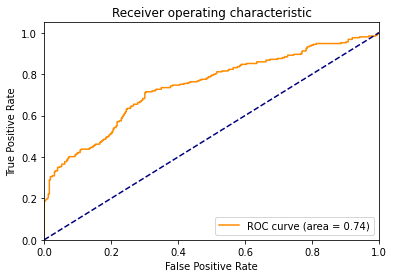

Optimal prediction threshold: 0.07040
Optimal prediction threshold: 0.99088
AUC for MCI vs. CN = 0.68
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.680
AUC for AD vs. CN = 0.927
Acc for MCI vs. CN = 66.3
Acc for AD vs. CN = 78.9
confusion matrix (naive)
[[249  77]
 [  0   0]
 [ 96  91]
 [  5  57]]
oAcc for MCI vs. CN = 67.3
oAcc for AD vs. CN = 88.1
confusion matrix (optimized)
[[227  99]
 [  0   0]
 [ 69 118]
 [  3  59]]
validating model newmodel/newmodel_wb_cv8.hdf5
Test accuracy: 66.61 %


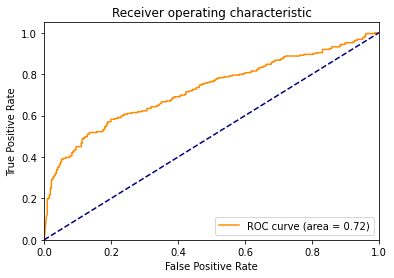

Optimal prediction threshold: 0.92473
Optimal prediction threshold: 0.99626
AUC for MCI vs. CN = 0.66
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.660
AUC for AD vs. CN = 0.918
Acc for MCI vs. CN = 63.7
Acc for AD vs. CN = 73.2
confusion matrix (naive)
[[228  98]
 [  0   0]
 [ 88  99]
 [  6  56]]
oAcc for MCI vs. CN = 70.2
oAcc for AD vs. CN = 92.0
confusion matrix (optimized)
[[282  44]
 [  0   0]
 [109  78]
 [ 12  50]]
validating model newmodel/newmodel_wb_cv9.hdf5
Test accuracy: 71.13 %


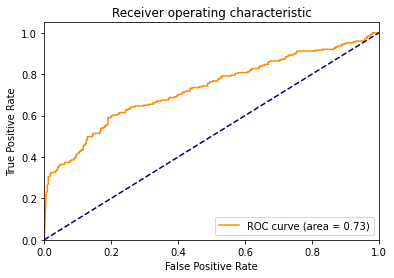

Optimal prediction threshold: 0.51690
Optimal prediction threshold: 0.64514
AUC for MCI vs. CN = 0.67
AUC for AD vs. CN = 0.91
AUC for MCI vs. CN = 0.670
AUC for AD vs. CN = 0.910
Acc for MCI vs. CN = 69.0
Acc for AD vs. CN = 80.9
confusion matrix (naive)
[[259  67]
 [  0   0]
 [ 92  95]
 [  7  55]]
oAcc for MCI vs. CN = 69.2
oAcc for AD vs. CN = 82.5
confusion matrix (optimized)
[[261  65]
 [  0   0]
 [ 93  94]
 [  8  54]]
validating model newmodel/newmodel_wb_cv10.hdf5
Test accuracy: 64.52 %


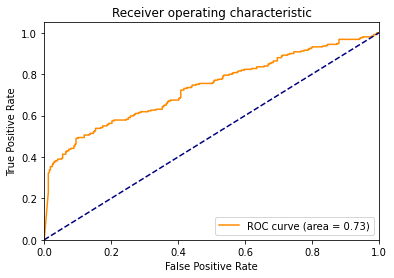

Optimal prediction threshold: 0.98061
Optimal prediction threshold: 0.99767
AUC for MCI vs. CN = 0.67
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.667
AUC for AD vs. CN = 0.933
Acc for MCI vs. CN = 60.6
Acc for AD vs. CN = 64.2
confusion matrix (naive)
[[189 137]
 [  0   0]
 [ 65 122]
 [  2  60]]
oAcc for MCI vs. CN = 69.6
oAcc for AD vs. CN = 88.9
confusion matrix (optimized)
[[276  50]
 [  0   0]
 [106  81]
 [ 10  52]]
validating model newmodel/newmodel_wb_cv11.hdf5
Test accuracy: 64.87 %


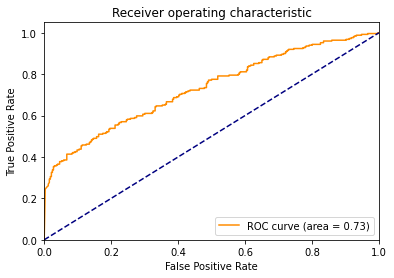

Optimal prediction threshold: 0.95747
Optimal prediction threshold: 0.99996
AUC for MCI vs. CN = 0.67
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.667
AUC for AD vs. CN = 0.924
Acc for MCI vs. CN = 61.6
Acc for AD vs. CN = 69.1
confusion matrix (naive)
[[211 115]
 [  0   0]
 [ 82 105]
 [  5  57]]
oAcc for MCI vs. CN = 66.5
oAcc for AD vs. CN = 93.3
confusion matrix (optimized)
[[257  69]
 [  0   0]
 [103  84]
 [  9  53]]
validating model newmodel/newmodel_wb_cv12.hdf5
Test accuracy: 67.83 %


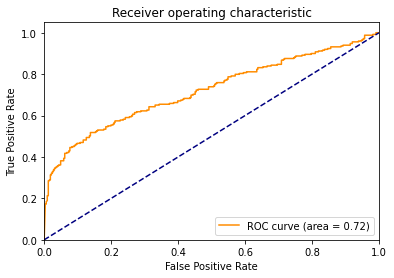

Optimal prediction threshold: 0.92459
Optimal prediction threshold: 0.97040
AUC for MCI vs. CN = 0.66
AUC for AD vs. CN = 0.91
AUC for MCI vs. CN = 0.656
AUC for AD vs. CN = 0.912
Acc for MCI vs. CN = 65.3
Acc for AD vs. CN = 76.8
confusion matrix (naive)
[[243  83]
 [  0   0]
 [ 95  92]
 [  7  55]]
oAcc for MCI vs. CN = 69.4
oAcc for AD vs. CN = 88.1
confusion matrix (optimized)
[[281  45]
 [  0   0]
 [112  75]
 [  9  53]]
validating model newmodel/newmodel_wb_cv13.hdf5
Test accuracy: 70.26 %


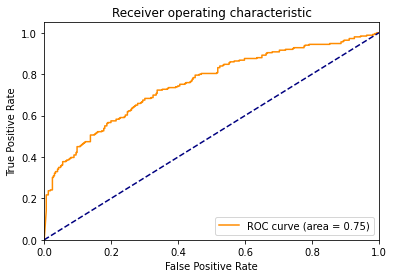

Optimal prediction threshold: 0.00665
Optimal prediction threshold: 0.29265
AUC for MCI vs. CN = 0.70
AUC for AD vs. CN = 0.91
AUC for MCI vs. CN = 0.702
AUC for AD vs. CN = 0.909
Acc for MCI vs. CN = 69.6
Acc for AD vs. CN = 85.8
confusion matrix (naive)
[[286  40]
 [  0   0]
 [116  71]
 [ 15  47]]
oAcc for MCI vs. CN = 65.9
oAcc for AD vs. CN = 84.5
confusion matrix (optimized)
[[216 110]
 [  0   0]
 [ 65 122]
 [  5  57]]
validating model newmodel/newmodel_wb_cv14.hdf5
Test accuracy: 67.65 %


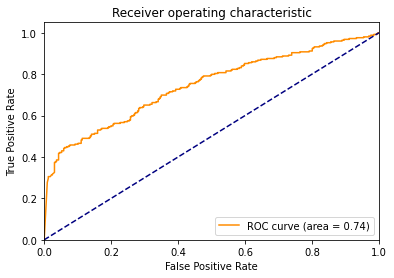

Optimal prediction threshold: 0.99784
Optimal prediction threshold: 0.99949
AUC for MCI vs. CN = 0.68
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.680
AUC for AD vs. CN = 0.936
Acc for MCI vs. CN = 64.3
Acc for AD vs. CN = 75.5
confusion matrix (naive)
[[234  92]
 [  0   0]
 [ 91  96]
 [  3  59]]
oAcc for MCI vs. CN = 71.0
oAcc for AD vs. CN = 91.8
confusion matrix (optimized)
[[301  25]
 [  0   0]
 [124  63]
 [ 12  50]]
validating model newmodel/newmodel_wb_cv15.hdf5
Test accuracy: 64.87 %


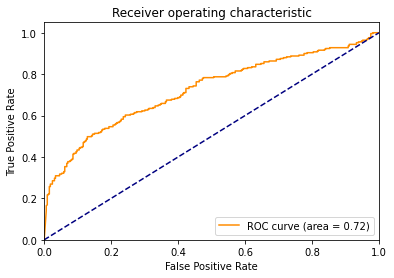

Optimal prediction threshold: 0.80372
Optimal prediction threshold: 0.98344
AUC for MCI vs. CN = 0.66
AUC for AD vs. CN = 0.91
AUC for MCI vs. CN = 0.662
AUC for AD vs. CN = 0.907
Acc for MCI vs. CN = 61.8
Acc for AD vs. CN = 68.0
confusion matrix (naive)
[[208 118]
 [  0   0]
 [ 78 109]
 [  6  56]]
oAcc for MCI vs. CN = 66.7
oAcc for AD vs. CN = 86.3
confusion matrix (optimized)
[[247  79]
 [  0   0]
 [ 92  95]
 [  8  54]]
validating model newmodel/newmodel_wb_cv16.hdf5
Test accuracy: 67.48 %


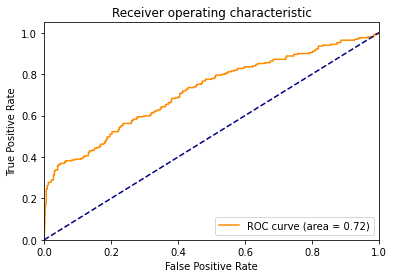

Optimal prediction threshold: 0.01672
Optimal prediction threshold: 0.99898
AUC for MCI vs. CN = 0.66
AUC for AD vs. CN = 0.90
AUC for MCI vs. CN = 0.656
AUC for AD vs. CN = 0.904
Acc for MCI vs. CN = 65.1
Acc for AD vs. CN = 78.4
confusion matrix (naive)
[[250  76]
 [  0   0]
 [103  84]
 [  8  54]]
oAcc for MCI vs. CN = 59.1
oAcc for AD vs. CN = 92.0
confusion matrix (optimized)
[[169 157]
 [  0   0]
 [ 53 134]
 [  4  58]]
validating model newmodel/newmodel_wb_cv17.hdf5
Test accuracy: 66.78 %


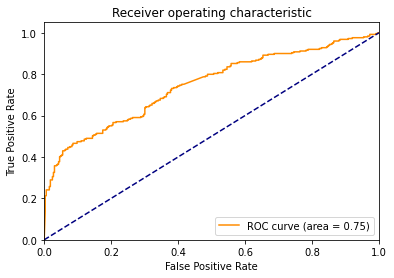

Optimal prediction threshold: 0.30293
Optimal prediction threshold: 0.99563
AUC for MCI vs. CN = 0.68
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.683
AUC for AD vs. CN = 0.933
Acc for MCI vs. CN = 63.5
Acc for AD vs. CN = 71.4
confusion matrix (naive)
[[219 107]
 [  0   0]
 [ 80 107]
 [  4  58]]
oAcc for MCI vs. CN = 63.0
oAcc for AD vs. CN = 91.8
confusion matrix (optimized)
[[202 124]
 [  0   0]
 [ 66 121]
 [  3  59]]
validating model newmodel/newmodel_wb_cv18.hdf5
Test accuracy: 69.39 %


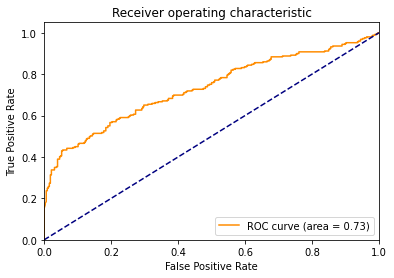

Optimal prediction threshold: 0.19348
Optimal prediction threshold: 0.98595
AUC for MCI vs. CN = 0.67
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.667
AUC for AD vs. CN = 0.927
Acc for MCI vs. CN = 66.9
Acc for AD vs. CN = 80.2
confusion matrix (naive)
[[255  71]
 [  0   0]
 [ 99  88]
 [  6  56]]
oAcc for MCI vs. CN = 64.9
oAcc for AD vs. CN = 91.0
confusion matrix (optimized)
[[229  97]
 [  0   0]
 [ 83 104]
 [  5  57]]
validating model newmodel/newmodel_wb_cv19.hdf5
Test accuracy: 64.70 %


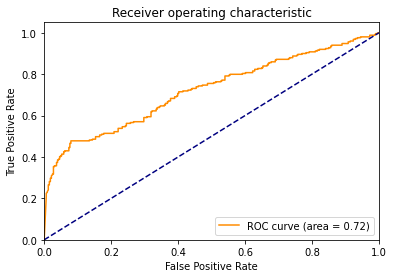

Optimal prediction threshold: 0.99809
Optimal prediction threshold: 0.99800
AUC for MCI vs. CN = 0.65
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.651
AUC for AD vs. CN = 0.929
Acc for MCI vs. CN = 61.0
Acc for AD vs. CN = 65.7
confusion matrix (naive)
[[196 130]
 [  0   0]
 [ 70 117]
 [  3  59]]
oAcc for MCI vs. CN = 71.2
oAcc for AD vs. CN = 90.7
confusion matrix (optimized)
[[300  26]
 [  0   0]
 [122  65]
 [ 10  52]]
validating model newmodel/newmodel_wb_cv20.hdf5
Test accuracy: 65.74 %


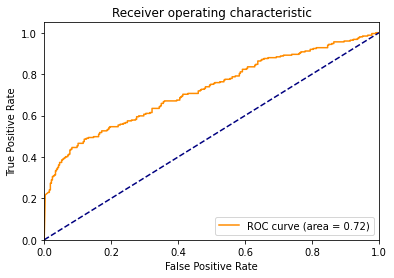

Optimal prediction threshold: 0.99605
Optimal prediction threshold: 0.99121
AUC for MCI vs. CN = 0.66
AUC for AD vs. CN = 0.91
AUC for MCI vs. CN = 0.662
AUC for AD vs. CN = 0.912
Acc for MCI vs. CN = 63.0
Acc for AD vs. CN = 70.9
confusion matrix (naive)
[[220 106]
 [  0   0]
 [ 84 103]
 [  7  55]]
oAcc for MCI vs. CN = 70.2
oAcc for AD vs. CN = 86.9
confusion matrix (optimized)
[[293  33]
 [  0   0]
 [120  67]
 [ 14  48]]


In [7]:
# Split data into training/validation and holdout test data
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
import gc
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # model will be trained on GPU 0

import keras
from keras import layers
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.optimizers import Adam
from keras import initializers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from statistics import mean,stdev
from sklearn.metrics import confusion_matrix

acc_test, auc_test, auc_AD, auc_MCI = [], [], [], []
acc_AD, acc_MCI, opt_acc_AD, opt_acc_MCI = [], [], [], []
acc_AD, acc_MCI, auc_AD, auc_MCI = [], [], [], []
opt_acc_AD, opt_acc_MCI = [], []
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
opt_ppv_AD, opt_ppv_MCI, opt_npv_AD, opt_npv_MCI = [], [], [], []
opt_sen_AD, opt_sen_MCI, opt_spec_AD, opt_spec_MCI = [], [], [], []
f1_AD, f1_MCI, opt_f1_AD, opt_f1_MCI = [], [], [], []

num_kfold = 20 # number of cross-validation loops equal to number of models
batch_size = 8

for k in range(num_kfold):
    gc.collect()
    print('validating model newmodel/newmodel_wb_cv%d.hdf5' % (k+1))
    mymodel = models.load_model('newmodel/newmodel_wb_cv%d.hdf5' % (k+1))
    
    # Calculate accuracy for validation data
    #scores = mymodel.evaluate(images, labels, batch_size=batch_size) #, verbose=0
    #print("Test %s: %.2f%%" % (mymodel.metrics_names[1], scores[1]*100))
    #acc_test.append(scores[1]*100)
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(images, batch_size=batch_size)
    acc_all = np.mean((labels[:, 1] == np.round(pred[:, 1])).astype(int))*100
    print("Test accuracy: %.2f %%" % acc_all)
    acc_test.append(acc_all)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    opt_acc = dict()
    thresh = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    auc_test.append(roc_auc[1])
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [3,4]:
      grpi = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], thresholds = roc_curve(labels[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      thresh[i] = thresholds[np.argmax(tpr[i] - fpr[i])]
      print('Optimal prediction threshold: %0.5f' % thresh[i])
      acc[i] = np.mean((labels[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100
      opt_acc[i] = np.mean((labels[grpidx, 1] == (pred[grpidx, 1]>thresh[i]).astype(int)).astype(int))*100

    print('AUC for MCI vs. CN = %0.2f' % roc_auc[3])
    print('AUC for AD vs. CN = %0.2f' % roc_auc[4])
    auc_AD.append(roc_auc[4])
    auc_MCI.append(roc_auc[3])
    acc_AD.append(acc[4])
    acc_MCI.append(acc[3])
    opt_acc_AD.append(opt_acc[4])
    opt_acc_MCI.append(opt_acc[3])
    
    print('AUC for MCI vs. CN = %0.3f' % roc_auc[3])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[4])
    print('Acc for MCI vs. CN = %0.1f' % acc[3])
    print('Acc for AD vs. CN = %0.1f' % acc[4])
    print('confusion matrix (naive)')
    confmat = confusion_matrix(grps.Group-1, np.round(pred[:, 1]))
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)
    print(confmat[:,(0,1)])
    print('oAcc for MCI vs. CN = %0.1f' % opt_acc[3])
    print('oAcc for AD vs. CN = %0.1f' % opt_acc[4])
    print('confusion matrix (optimized)')
    confmat = confusion_matrix(grps.Group-1, (pred[:, 1]>thresh[3]).astype(int)) ## use MCI threshold
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    opt_sen_MCI.append(sen); opt_spec_MCI.append(spec); opt_ppv_MCI.append(ppv); opt_npv_MCI.append(npv); opt_f1_MCI.append(f1)
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    opt_sen_AD.append(sen); opt_spec_AD.append(spec); opt_ppv_AD.append(ppv); opt_npv_AD.append(npv); opt_f1_AD.append(f1)
    print(confmat[:,(0,1)])

In [8]:
# print model performance summary
from statistics import mean,stdev
print('Acc for all test data = %0.1f +/- %0.1f' % (mean(acc_test), stdev(acc_test)))
print('AUC for all test data = %0.3f +/- %0.3f' % (mean(auc_test), stdev(auc_test)))
print('AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))
print('Mean Acc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(acc_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.1f +/- %0.1f' % (mean(acc_AD), stdev(acc_AD)))
print('Mean oAcc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_MCI), stdev(opt_acc_MCI)))
print('Mean oAcc for AD vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_AD), stdev(opt_acc_AD)))

Acc for all test data = 66.6 +/- 2.4
AUC for all test data = 0.730 +/- 0.014
AUC for MCI vs. CN = 0.667 +/- 0.016
AUC for AD vs. CN = 0.919 +/- 0.015
Mean Acc for MCI vs. CN = 63.7 +/- 2.9
Mean Acc for AD vs. CN = 72.5 +/- 6.2
Mean oAcc for MCI vs. CN = 67.4 +/- 3.2
Mean oAcc for AD vs. CN = 88.5 +/- 3.2


In [9]:
print('Mean Sen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(sen_MCI)))
print('Mean Sen for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(sen_AD)))
print('Mean oSen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_sen_MCI), stdev(opt_sen_MCI)))
print('Mean oSen for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_sen_AD), stdev(opt_sen_AD)))

print('Mean Spec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(spec_MCI), stdev(spec_MCI)))
print('Mean Spec for AD vs. CN = %0.3f +/- %0.3f' % (mean(spec_AD), stdev(spec_AD)))
print('Mean oSpec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_spec_MCI), stdev(opt_spec_MCI)))
print('Mean oSpec for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_spec_AD), stdev(opt_spec_AD)))

print('Mean PPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(ppv_MCI), stdev(ppv_MCI)))
print('Mean PPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(ppv_AD), stdev(ppv_AD)))
print('Mean oPPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_ppv_MCI), stdev(opt_ppv_MCI)))
print('Mean oPPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_ppv_AD), stdev(opt_ppv_AD)))

print('Mean NPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(npv_MCI), stdev(npv_MCI)))
print('Mean NPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(npv_AD), stdev(npv_AD)))
print('Mean oNPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_npv_MCI), stdev(opt_npv_MCI)))
print('Mean oNPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_npv_AD), stdev(opt_npv_AD)))

print('Mean F1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(f1_MCI), stdev(f1_MCI)))
print('Mean F1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(f1_AD), stdev(f1_AD)))
print('Mean oF1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_f1_MCI), stdev(opt_f1_MCI)))
print('Mean oF1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_f1_AD), stdev(opt_f1_AD)))

Mean Sen for MCI vs. CN = 0.542 +/- 0.065
Mean Sen for AD vs. CN = 0.907 +/- 0.047
Mean oSen for MCI vs. CN = 0.484 +/- 0.117
Mean oSen for AD vs. CN = 0.864 +/- 0.060
Mean Spec for MCI vs. CN = 0.691 +/- 0.079
Mean Spec for AD vs. CN = 0.691 +/- 0.079
Mean oSpec for MCI vs. CN = 0.783 +/- 0.112
Mean oSpec for AD vs. CN = 0.783 +/- 0.112
Mean PPV for MCI vs. CN = 0.509 +/- 0.046
Mean PPV for AD vs. CN = 0.368 +/- 0.063
Mean oPPV for MCI vs. CN = 0.586 +/- 0.078
Mean oPPV for AD vs. CN = 0.466 +/- 0.120
Mean NPV for MCI vs. CN = 0.725 +/- 0.010
Mean NPV for AD vs. CN = 0.976 +/- 0.010
Mean oNPV for MCI vs. CN = 0.729 +/- 0.021
Mean oNPV for AD vs. CN = 0.969 +/- 0.010
Mean F1 for MCI vs. CN = 0.600 +/- 0.021
Mean F1 for AD vs. CN = 0.780 +/- 0.041
Mean oF1 for MCI vs. CN = 0.579 +/- 0.055
Mean oF1 for AD vs. CN = 0.813 +/- 0.048


In [10]:
results = pd.DataFrame({'Accuracy_Test':acc_test, 'AUC_Test':auc_test, 'AUC_MCI':auc_MCI, 'AUC_AD':auc_AD,
                        'Acc_MCI':acc_MCI, 'Acc_AD':acc_AD,
                        'Opt_acc_MCI':opt_acc_MCI, 'Opt_acc_AD':opt_acc_AD})
print(results)

    Accuracy_Test  AUC_Test   AUC_MCI    AUC_AD    Acc_MCI     Acc_AD  \
0       65.391304  0.727961  0.664307  0.919949  62.573099  69.587629   
1       64.000000  0.735691  0.672206  0.927172  60.428850  64.690722   
2       62.260870  0.688114  0.626357  0.874382  59.454191  65.206186   
3       64.869565  0.716442  0.645624  0.930042  61.013645  68.556701   
4       69.217391  0.742288  0.678062  0.936003  66.276803  75.773196   
5       64.869565  0.743366  0.685181  0.918860  61.598441  68.041237   
6       69.043478  0.741463  0.679850  0.927296  66.276803  78.865979   
7       66.608696  0.724456  0.660149  0.918415  63.742690  73.195876   
8       71.130435  0.729328  0.669540  0.909658  69.005848  80.927835   
9       64.521739  0.733012  0.666866  0.932515  60.623782  64.175258   
10      64.869565  0.731115  0.667153  0.924030  61.598441  69.072165   
11      67.826087  0.719892  0.656105  0.912280  65.302144  76.804124   
12      70.260870  0.753431  0.701814  0.909113  69